In [2]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from scipy.misc import imsave
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing import image

F:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from scipy.optimize import fmin_l_bfgs_b

In [5]:
def VGG16_AvgPool(shape):
    """
    Replace max pooling layers with average pooling layer
    """
    vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)
    
    new_model = Sequential()
    for layer in vgg.layers:
        if layer.__class__ == MaxPooling2D:
            # Replace it wht average pooling
            new_model.add(AveragePooling2D())
        else:
            new_model.add(layer)
    return new_model

In [6]:
def VGG16_AvgPool_CutOff(shape, num_convs):
    """
    """
    if num_convs < 1 or num_convs > 13:
        print("num_convs must be in the range [1, 13]")
        return None
    
    model = VGG16_AvgPool(shape)
    new_model = Sequential()
    n = 0
    for layer in model.layers:
        if layer.__class__ == Conv2D:
            n += 1
        new_model.add(layer)
        if n >= num_convs:
            break
    return new_model

In [7]:
def unpreprocess(img):
    """
    Reverse the Keras preprocess_input --> Can show image with matplotlib
    """
    img[..., 0] += 103.939
    img[..., 1] += 116.779
    img[..., 2] += 126.68
    img = img[..., ::-1]
    return img

In [8]:
def scale_img(x):
    x = x - x.min()
    x = x / x.max()
    return x

In [9]:
def get_loss_and_grads_wrapper(x_vec):
    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)

In [10]:
path = './images/image_0002.jpg'
img = image.load_img(path)
    
# convert image to array and preprocess for vgg
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)    

In [11]:
# Shape = [B, H, W, C]
batch_shape = x.shape
shape = x.shape[1:]

In [ ]:
content_model = VGG16_AvgPool_CutOff(shape, 5)
    
target = K.variable(content_model.predict(x))
    
loss = K.mean(K.square(target - content_model.output))
    
#grads = K.gradients(loss, content_model.input)
    
get_loss_and_grads = K.function(
    inputs=[content_model.input],
    outputs=[loss, K.gradients(loss,x)]
    )

In [ ]:
from datetime import datetime
t0 = datetime.now()
losses = []
x = np.random.randn(np.prod(batch_shape))

for i in range(10):
    x, l, _ = fmin_l_bfgs_b(func=get_loss_and_grads_wrapper, x0=x, maxfun=20)
    x = np.clip(x, -127, 127)
    print("iter={}, loss={}".format(i, l))
    losses.append(l)
print("duration:", datetime.now() - t0)
plt.plot(losses)

In [ ]:
newimg = x.reshape(*batch_shape)
final_img = unpreprocess(newimg)
print(newimg.shape)
plt.imshow(scale_img(final_img[0]))

In [8]:
def gram_matrix(img):
    X = K.batch_flatten(K.permute_dimensions(img, (2, 0, 1)))
    
    G = K.dot(X, K.transpose(X)) / img.get_shape().num_elements()
    return G

In [9]:
def style_loss(y, t):
    return K.mean(K.square(gram_matrix(y) - gram_matrix(t)))

In [10]:
def minimize(fn, epochs, batch_shape):
    from datetime import datetime
    t0 = datetime.now()
    losses = []
    x = np.random.randn(np.prod(batch_shape))
    for i in range(epochs):
        x, l, _ = fmin_l_bfgs_b(func=fn, x0=x, maxfun=20)
        x = np.clip(x, -127, 127)
        print("iter={}, loss={}".format(i, l))
        losses.append(l)
        
    print("duration:", datetime.now() - t0)
    plt.plot(losses)
    
    newimg = x.reshape(*batch_shape)
    final_img = unpreprocess(newimg)
    return final_img[0]

In [27]:
path = 'images/seated.jpg'

In [28]:
img = image.load_img(path)
x = image.img_to_array(img)

In [29]:
x = np.expand_dims(x, axis=0)

In [30]:
x = preprocess_input(x)

In [31]:
# Shape = [B, H, W, C]
batch_shape = x.shape
shape = x.shape[1:]

In [32]:
vgg = VGG16_AvgPool(shape)

In [33]:
symbolic_conv_outputs = [layer.get_output_at(1) for layer in vgg.layers if layer.name.endswith('conv1')]

In [34]:
multi_output_model = Model(vgg.input, symbolic_conv_outputs)

In [35]:
style_layers_outputs = [K.variable(y) for y in multi_output_model.predict(x)]

In [36]:
loss = 0
for symbolic, actual in zip(symbolic_conv_outputs, style_layers_outputs):
    loss += style_loss(symbolic[0], actual[0])

grads = K.gradients(loss, multi_output_model.input)


In [37]:
get_loss_and_grads = K.function(inputs=[multi_output_model.input], outputs=[loss] + grads)

iter=0, loss=7260.48779296875
iter=1, loss=1120.1611328125
iter=2, loss=60.22526168823242
iter=3, loss=14.51750659942627
iter=4, loss=8.010937690734863
iter=5, loss=5.321441650390625
iter=6, loss=3.8961784839630127
iter=7, loss=3.457266092300415
iter=8, loss=3.3913774490356445
iter=9, loss=3.390481472015381
duration: 0:00:58.955240


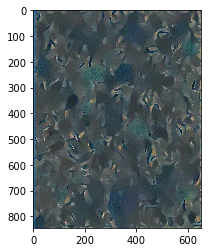

In [38]:
final_img = minimize(get_loss_and_grads_wrapper, 10, batch_shape)
plt.imshow(scale_img(final_img))

In [129]:
con_img = plt.imread('./images/stata.jpg')
stl_img = plt.imread('./images/test.jpg')

In [12]:
def load_img_and_preprocess(path, shape=None):
    img = image.load_img(path, target_size=shape)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    return x

In [83]:
content_img = load_img_and_preprocess('./images/stata.jpg')
content_img.shape

(1, 679, 1024, 3)

In [84]:
h, w = content_img.shape[1:3]

In [85]:
style_img = load_img_and_preprocess('./images/test.jpg', (h, w))
style_img.shape

(1, 679, 1024, 3)

In [86]:
batch_shape = content_img.shape
shape = content_img.shape[1:]

In [87]:
vgg = VGG16_AvgPool(shape)

In [88]:
#vgg.summary()

In [89]:
content_model = Model(vgg.input, vgg.layers[13].get_output_at(1))
content_target = K.variable(content_model.predict(content_img))

In [90]:
symbolic_conv_outputs = [layer.get_output_at(1) for layer in vgg.layers if layer.name.endswith('conv1')]
symbolic_conv_outputs

[<tf.Tensor 'block1_conv1_11/Relu:0' shape=(?, 679, 1024, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1_11/Relu:0' shape=(?, 339, 512, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1_11/Relu:0' shape=(?, 169, 256, 256) dtype=float32>,
 <tf.Tensor 'block4_conv1_11/Relu:0' shape=(?, 84, 128, 512) dtype=float32>,
 <tf.Tensor 'block5_conv1_11/Relu:0' shape=(?, 42, 64, 512) dtype=float32>]

In [91]:
style_model = Model(vgg.input, symbolic_conv_outputs)

In [92]:
style_layers_outputs = [K.variable(y) for y in style_model.predict(style_img)]

In [142]:
style_weigts = [0.1, 0.5, 0.5, 0.5, 0.5]

In [143]:
loss = K.mean(K.square(content_model.output - content_target))

In [144]:
for w, symbolic, actual in zip(style_weigts, symbolic_conv_outputs, style_layers_outputs):
    loss += w * style_loss(symbolic[0], actual[0])

In [145]:
grads = K.gradients(loss, vgg.input)

In [146]:
get_loss_and_grads = K.function(inputs=[vgg.input], outputs=[loss] + grads)

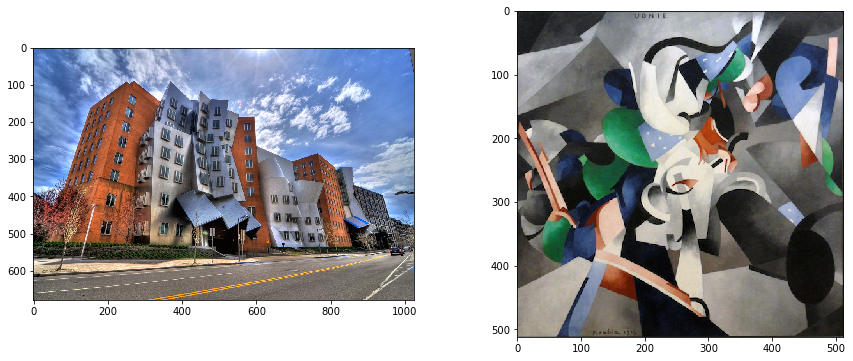

In [147]:
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plt.imshow(con_img)

plt.subplot(1, 2, 2)
plt.imshow(stl_img)
plt.show()


iter=0, loss=4140.81005859375
iter=1, loss=1703.3529052734375
iter=2, loss=1073.5958251953125
iter=3, loss=837.0449829101562
iter=4, loss=693.1041259765625
iter=5, loss=589.9392700195312
iter=6, loss=519.5429077148438
iter=7, loss=469.2974548339844
iter=8, loss=429.57989501953125
iter=9, loss=396.017822265625
iter=10, loss=369.00823974609375
iter=11, loss=344.7494812011719
iter=12, loss=326.6361389160156
iter=13, loss=310.1159973144531
iter=14, loss=297.13494873046875
iter=15, loss=286.21630859375
iter=16, loss=276.43719482421875
iter=17, loss=267.84796142578125
iter=18, loss=260.17144775390625
iter=19, loss=252.85496520996094
iter=20, loss=245.74331665039062
iter=21, loss=240.11239624023438
iter=22, loss=234.72634887695312
iter=23, loss=229.8863983154297
iter=24, loss=225.31556701660156
iter=25, loss=221.08026123046875
iter=26, loss=217.1528778076172
iter=27, loss=213.59535217285156
iter=28, loss=210.1002197265625
iter=29, loss=206.5646514892578
iter=30, loss=203.26873779296875
iter=3

iter=247, loss=102.14656829833984
iter=248, loss=102.06424713134766
iter=249, loss=101.99004364013672
iter=250, loss=101.91682434082031
iter=251, loss=101.84099578857422
iter=252, loss=101.76978302001953
iter=253, loss=101.70133972167969
iter=254, loss=101.62841796875
iter=255, loss=101.56101989746094
iter=256, loss=101.49452209472656
iter=257, loss=101.4236831665039
iter=258, loss=101.35765838623047
iter=259, loss=101.29439544677734
iter=260, loss=101.22858428955078
iter=261, loss=101.16395568847656
iter=262, loss=101.09659576416016
iter=263, loss=101.03462219238281
iter=264, loss=100.97193145751953
iter=265, loss=100.91000366210938
iter=266, loss=100.84343719482422
iter=267, loss=100.78041076660156
iter=268, loss=100.7203598022461
iter=269, loss=100.6534423828125
iter=270, loss=100.59290313720703
iter=271, loss=100.52922821044922
iter=272, loss=100.47162628173828
iter=273, loss=100.4088134765625
iter=274, loss=100.34871673583984
iter=275, loss=100.28739929199219
iter=276, loss=100.22

iter=497, loss=91.7237777709961
iter=498, loss=91.69915771484375
iter=499, loss=91.67723846435547
duration: 1:09:54.825915


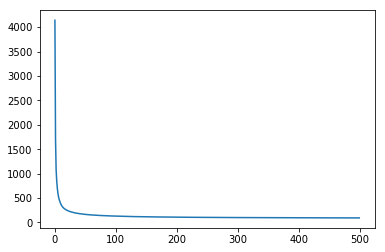

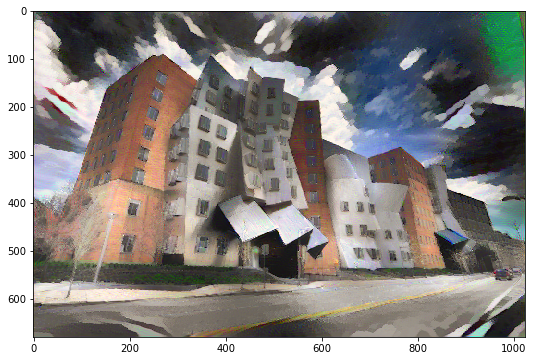

In [153]:
final_img = minimize(get_loss_and_grads_wrapper, 500, batch_shape)

plt.figure(figsize=(15,6))
plt.imshow(scale_img(final_img))

In [154]:
type(final_img)

numpy.ndarray

In [156]:
imsave('styled_img.jpg', final_img)

In [24]:
content_img = load_img_and_preprocess('./images/tue.jpg')
content_img.shape

h, w = content_img.shape[1:3]

style_img = load_img_and_preprocess('./images/star.jpg', (h, w))

In [25]:
batch_shape = content_img.shape
shape = content_img.shape[1:]

In [26]:
vgg = VGG16_AvgPool(shape)
content_model = Model(vgg.input, vgg.layers[13].get_output_at(1))
content_target = K.variable(content_model.predict(content_img))

In [27]:
symbolic_conv_outputs = [layer.get_output_at(1) for layer in vgg.layers if layer.name.endswith('conv1')]
symbolic_conv_outputs

[<tf.Tensor 'block1_conv1_3/Relu:0' shape=(?, 768, 1024, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1_3/Relu:0' shape=(?, 384, 512, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1_3/Relu:0' shape=(?, 192, 256, 256) dtype=float32>,
 <tf.Tensor 'block4_conv1_3/Relu:0' shape=(?, 96, 128, 512) dtype=float32>,
 <tf.Tensor 'block5_conv1_3/Relu:0' shape=(?, 48, 64, 512) dtype=float32>]

In [28]:
style_model = Model(vgg.input, symbolic_conv_outputs)

In [29]:
style_layers_outputs = [K.variable(y) for y in style_model.predict(style_img)]

In [30]:
style_weigts = [0.1, 0.5, 0.5, 0.5, 0.5]
loss = K.mean(K.square(content_model.output - content_target))

In [31]:
for w, symbolic, actual in zip(style_weigts, symbolic_conv_outputs, style_layers_outputs):
    loss += w * style_loss(symbolic[0], actual[0])

In [32]:
grads = K.gradients(loss, vgg.input)

In [33]:
get_loss_and_grads = K.function(inputs=[vgg.input], outputs=[loss] + grads)

iter=0, loss=5610.2685546875
iter=1, loss=880.1699829101562
iter=2, loss=542.6539916992188
iter=3, loss=429.5971984863281
iter=4, loss=372.57318115234375
iter=5, loss=324.93499755859375
iter=6, loss=288.3135070800781
iter=7, loss=257.9878234863281
iter=8, loss=233.38233947753906
iter=9, loss=214.67532348632812
iter=10, loss=200.13694763183594
iter=11, loss=187.9274139404297
iter=12, loss=179.47706604003906
iter=13, loss=172.63616943359375
iter=14, loss=166.88980102539062
iter=15, loss=161.71881103515625
iter=16, loss=157.28453063964844
iter=17, loss=153.89736938476562
iter=18, loss=150.59104919433594
iter=19, loss=147.82208251953125
iter=20, loss=145.25875854492188
iter=21, loss=142.63392639160156
iter=22, loss=140.63192749023438
iter=23, loss=138.88087463378906
iter=24, loss=137.29551696777344
iter=25, loss=135.90982055664062
iter=26, loss=134.41473388671875
iter=27, loss=133.10113525390625
iter=28, loss=131.99398803710938
iter=29, loss=130.87115478515625
iter=30, loss=129.85688781738

iter=250, loss=93.26229095458984
iter=251, loss=93.21333312988281
iter=252, loss=93.18915557861328
iter=253, loss=93.14810943603516
iter=254, loss=93.1116714477539
iter=255, loss=93.07965850830078
iter=256, loss=93.03606414794922
iter=257, loss=93.01235961914062
iter=258, loss=92.96949005126953
iter=259, loss=92.9379653930664
iter=260, loss=92.90502166748047
iter=261, loss=92.87833404541016
iter=262, loss=92.83457946777344
iter=263, loss=92.79852294921875
iter=264, loss=92.76802062988281
iter=265, loss=92.72943115234375
iter=266, loss=92.69377899169922
iter=267, loss=92.66090393066406
iter=268, loss=92.63140869140625
iter=269, loss=92.59591674804688
iter=270, loss=92.5672607421875
iter=271, loss=92.53343200683594
iter=272, loss=92.50425720214844
iter=273, loss=92.46315002441406
iter=274, loss=92.43150329589844
iter=275, loss=92.39897155761719
iter=276, loss=92.36503601074219
iter=277, loss=92.32183837890625
iter=278, loss=92.3093032836914
iter=279, loss=92.27184295654297
iter=280, loss

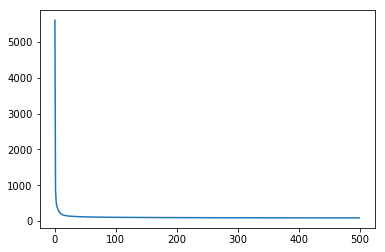

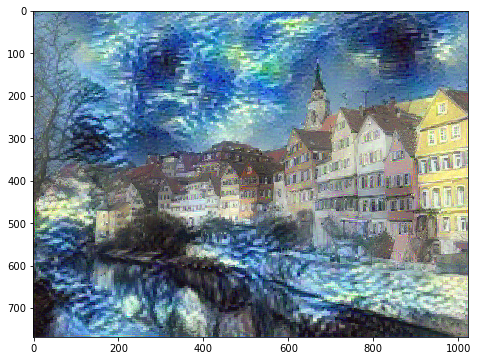

In [35]:
final_img = minimize(get_loss_and_grads_wrapper, 500, batch_shape)

plt.figure(figsize=(15,6))
plt.imshow(scale_img(final_img))